# Ikeda $B_e$ assumtion.
Using analytical linear decay solution to calculate the $B_e$

In [1]:
from rolldecayestimators import equations

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
The quadratic or cubic model can be expressed using the linearized equivalent damping ($B_e$) according to <cite data-cite="7505983/EYEMHSYH">. But I have some doubt about the validity of this, which will be investigated in this notebook.

In [2]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

# Methodology
The linear equivalent damping is basically about replacing a higher order model with a linear model. In this notebook a quadratic model is representing the higher order model.
The quadratic model has two damping coefficients $B_1$ and $B_2$ these to coefficients should be replaced by only one linear damping term $B_e$. <cite data-cite="7505983/FB64RGPF"></cite> suggests that the equation above can be used to combine $B_1$ and $B_2$ into one coefficient $B_e$.

I will use the least square fitting to find the linear equivalent damping that minimized the error when representing a quadratic model as a linear model. The analytical solution to the linear roll decay model will be used to get a fast and accurate prediction of the least square fit.

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [3]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


In [4]:
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import rolldecayestimators
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

## Quadratic

In [5]:
Math(vlatex(equations.roll_decay_equation_himeno_quadratic_b))

<IPython.core.display.Math object>

In [6]:
eq_acceleration_quadratic = sp.Eq(symbols.phi_dot_dot,
                        sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

accelaration_quadratic_lambda = lambdify(sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

Math(vlatex(eq_acceleration_quadratic))

<IPython.core.display.Math object>

In [7]:
class RollDecayQuadratic():
    
    def __init__(self,A_44, B_1, B_2, C_1):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'B_2':B_2,
            'C_1':C_1,
        }
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_quadratic_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt
    
    def simulate(self,t,phi0=np.deg2rad(10),phi1d0=0):
        
        initial_state = [phi0,phi1d0]
        
        t_span = [t[0], t[-1]]
        
        result = solve_ivp(fun=simulation.time_step, t_span=t_span,  y0=initial_state, t_eval=t)
        assert result.success
        df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])
        return df_result


## Select suitable paramter range

In [8]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.95, 
                             exclude_table_name='rolldecay_exclude')

In [9]:
df_rolldecay.head()

,model_number,loading_condition_id,ship_speed,B_1A,B_2A,C_1A,B_1,B_2,C_1,A_44,omega0,omega0_fft,score,phi_start,phi_stop,id,project_number,series_number,run_number,test_number,ship_name,ascii_name,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,project_path,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id
run_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7680,3416-A,64,20.0,0.227627,0.159501,13.955745,11.001140,7.708654,674.477676,48.329751,3.735739,3.738495,0.999343,-0.144160,-0.006098,7680,20115912,10,25,1,3416-A,20115912-2-ser010-k025-100hz.asc,Kursstyrning Roll decay med fart. med annan ro...,N:\Gamla_Projekt\ascii_files\20115912-2-ser010...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2012-01-04,roll decay,MDL,None,None,Kursstyrning,20115912_DSME_156k_singleskeg_LNG,\\sspa.local\gbg\ProjektArkiv\2011\20115912_DS...,1.250,12.32,9.58,0.827,9.4,9.4,44.00,16.8,69.90,NaN,0.7461,85209.0,0.9906,9.6,58.7000,279.0,44.00,NaN,7.500,0.0,NaN,19.6,NaN,NaN,0.871,NaN,None,None,18818.0,1.0,NaN,66.51,0.44,NaN,8.6,NaN,NaN,NaN,78.0,65.28,NaN,NaN,1.0,1.0,NaN,None,NaN,NaN,290.0,4.0
14848,3541-A,107,13.0,0.088786,0.442492,6.175780,6.821454,33.996705,474.485974,76.830134,2.485112,2.488141,0.999477,-0.138416,0.006405,14848,20136522,1,32,1,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2014-12-29,roll decay,MDL,None,None,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.190,18.38,3.80,0.847,11.5,11.5,46.97,15.5,65.32,3.36,0.7669,116472.0,0.9899,8.5,55.0000,284.0,46.97,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.00,None,None,20000.0,1.0,NaN,92.13,0.43,3.0,8.3,28.0,2.32,-123.0,67.8,49.40,0.0,0.0,2.0,1.0,-142.0,None,7.7,58.0,290.0,4.0
19968,M3653-A,152,18.5,0.220901,0.237796,8.327022,11.855481,12.762236,446.900757,53.668737,2.885658,2.890265,0.997549,0.141096,0.012100,19968,20167796,1,29,1,M3653-A,20167796-ser001-k029-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20167796-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2016-05-12,roll decay,MDL,None,None,Kursstyrning,20167796-DSME-180k-twin-skeg-LNGC,S:\2016\20167796-DSME-180k-twin-skeg-LNGC,-5.250,17.53,4.90,NaN,11.5,11.5,NaN,NaN,NaN,NaN,NaN,120490.0,NaN,NaN,60.0000,291.5,47.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
20485,M5044-01-A,159,0.0,0.059651,0.121928,9.916353,4.411278,9.016756,733.327006,73.951280,3.149024,3.154159,0.997167,0.155019,-0.003700,20485,20168119,101,10,1,M5044-01-A,20168119-ser101-k010-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20168119-ser101-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-02-23,roll decay,MDL,None,None,Kursstyrning,20168119-DSME-Tanker-Series-Additional-Tests,S:\2016\20168119-DSME-Tanker-Series-Additional...,7.840,14.68,5.89,NaN,16.0,16.0,NaN,NaN,NaN,NaN,NaN,164482.0,NaN,NaN,60.0000,266.0,48.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2570,3239-A,14,0.1,0.017279,0.525094,5.870454,1.869850,56.822711,635.267667,108.214410,2.422902,2.425310,0.999079,-0.151823,0.015199,2570,20074477,1,27,1,3239-A,20074477-ser001-k027-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20074477-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2007-11-20,roll decay,MDL,None,None,Kursstyrning,20074477,\\sspa.local\gbg\ProjektArkiv\2007\20074477,-0.953,17.40,3.89,0.843,11.5,11.5,45.80,15.1,66

In [10]:
interesting = ['B_1A','B_2A','C_1A']
df_rolldecay[interesting].describe()

,B_1A,B_2A,C_1A
count,2.220000e+02,222.000000,222.000000
mean,1.425475e-01,0.281687,9.042803
std,1.071491e-01,0.258985,4.378310
min,6.451552e-18,-0.662927,1.539731
25%,5.792787e-02,0.144445,5.915274
50%,1.167264e-01,0.241128,8.312634
75%,2.092812e-01,0.371055,11.348254
max,5.570938e-01,1.956472,25.363015


In [11]:
B_1A = df_rolldecay['B_1A'].median()
B_1A

0.11672637102335451

In [12]:
index = (df_rolldecay['B_1A']-B_1A).abs().argmin()
row = df_rolldecay.iloc[index]

In [13]:
row['B_1A']

0.118067357553941

In [14]:
B_max_ratio = (df_rolldecay['B_2A']/df_rolldecay['B_1A']).abs().quantile(0.95)

In [15]:
N=100000
A_44 = 2.2
B_1 = row['B_1A']*A_44
C_1 = row['C_1A']*A_44

simulations = {
}

N= 15
B_2_max = B_max_ratio*B_1
B_2s = np.linspace(0,B_2_max,N)
for B_2 in B_2s:
    simulations[B_2]=RollDecayQuadratic(A_44=A_44, B_1=B_1, B_2=B_2, C_1=C_1)

In [16]:
equations.C_equation_linear

Eq(C, GM*g*m)

In [17]:
A_44_eq = sp.Eq(symbols.A_44, equations.A44)
A_44_eq

Eq(A_44, GM*g*m/omega0**2)

In [18]:
eqs = [
    A_44_eq,
    equations.C_equation_linear,

]
omega0_eq = sp.Eq(symbols.omega0,sp.solve(eqs, symbols.omega0, symbols.GM)[1][0])
omega0_eq

Eq(omega0, sqrt(C/A_44))

In [19]:
omega0 = np.sqrt(C_1/A_44)
N_oscillations=10
t = np.arange(0,2*np.pi/omega0*N_oscillations,0.01)
phi0=np.deg2rad(10)
phi1d0 = 0
initial_state = [phi0,phi1d0]


results = {}
X_amplitudes = {}
for name,simulation in simulations.items():
    
    df_result = simulation.simulate(t=t, phi0=phi0, phi1d0=phi1d0)
    
    results[name]=df_result
    X_amplitudes[name]=rolldecayestimators.measure.calculate_amplitudes_and_damping(X=df_result)

In [20]:
#for name in results.keys():
#    fig,ax=plt.subplots()
#    df_result = results[name]
#    amplitudes = X_amplitudes[name]
#    df_result.plot(y='phi',ax=ax)
#    amplitudes.plot(y='phi_a', ax=ax)
#    ax.grid(True)
#    ax.set_title(name)

## $B_e$ from anayltica solution

In [21]:
Math(vlatex(equations.diff_eq))

<IPython.core.display.Math object>

In [22]:
Math(vlatex(equations.analytical_solution))

<IPython.core.display.Math object>

In [23]:
no_initial_speed = sp.simplify(equations.analytical_solution.subs(symbols.phi_0_dot,0))
Math(vlatex(no_initial_speed))

<IPython.core.display.Math object>

In [24]:
no_initial_speed_zeta_small = no_initial_speed.subs(
    [(sp.sqrt(1-symbols.zeta**2),1),
     (symbols.zeta*sp.sin(symbols.omega0*symbols.t),0),
    ])
Math(vlatex(no_initial_speed_zeta_small))

<IPython.core.display.Math object>

In [25]:
B_1_zeta_eq = sp.Eq(symbols.B_1, 2*symbols.zeta*symbols.omega0*symbols.A_44)
B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

In [26]:
eqs = [
    B_1_zeta_eq,    
    equations.analytical_solution,
      ]

analytical_solution_B_1 = sp.Eq(symbols.phi,
                                sp.simplify(sp.solve(eqs,symbols.zeta,symbols.phi)[0][1]))
analytical_solution_B_1

Eq(phi(t), (4*A_44**2*omega0**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) + 2*A_44**2*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2)*Derivative(phi_0(t), t) + A_44*B_1*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*phi_0(t)*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) - B_1**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2))*exp(-B_1*t/(2*A_44))/(4*A_44**2*omega0**2 - B_1**2))

In [27]:
analytical_lambda = lambdify(sp.solve(analytical_solution_B_1,symbols.phi)[0])

In [28]:
equations.extinction_equation

Eq(phi_a, phi_0(t)*exp(-omega0*t*zeta))

In [29]:
sp.Eq(symbols.zeta,sp.solve(equations.extinction_equation,symbols.zeta)[0])

Eq(zeta, log(phi_0(t)/phi_a)/(omega0*t))

In [30]:
def simulate(B_e,X,omega0,A_44):
    t = X.index
    initial_states = X.iloc[0]
    phi_0 = initial_states['phi']
    phi_01d= initial_states['phi1d']
    phi_pred = analytical_lambda(omega0=omega0, A_44=A_44, phi_0=phi_0, phi_01d=phi1d0, t=t, B_1=B_e)
    return phi_pred

def residuals(B_e,X,omega0,A_44):
    
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    residual = phi_pred - X['phi']
    return residual

In [31]:
def linear_equivalent(X,omega0,A_44):
    kwargs={
        'X':X,
        'omega0':omega0,
        'A_44':A_44,
    }
    initial_guess = [B_1]
    result = least_squares(fun=residuals, x0=initial_guess, kwargs=kwargs, method='lm')
    assert result.success is True
    B_e = result.x[0]
    return B_e

0.9999674201528168

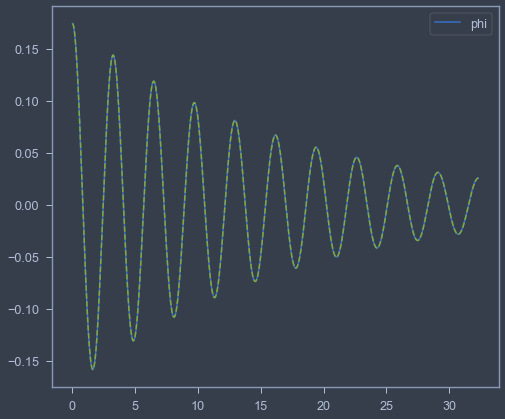

In [37]:
X = results[0]
omega0 = np.sqrt(C_1/A_44)

B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
phi_error = X['phi'] - phi_pred

fig,ax=plt.subplots()
X.plot(y='phi',ax=ax)
ax.plot(t,phi_pred,'--')

r2_score(y_true=X['phi'], y_pred=phi_pred)

In [38]:
df_B_e = pd.DataFrame()
df_B_e.index.name='B_2'

for B_2, X in results.items():
    B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'B_e'] = B_e
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2'] = r2_score(y_true=X['phi'], y_pred=phi_pred)
    
    B_e_himeno = lambdas.B_e_lambda(B_1=B_1, B_2=B_2, omega0=omega0, phi_a=phi0)
    df_B_e.loc[B_2,'B_e_himeno'] = B_e_himeno
    phi_pred_himeno = simulate(B_e=B_e_himeno, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2_himeno'] = r2_score(y_true=X['phi'], y_pred=phi_pred_himeno)

df_B_e['B_1'] = B_1

Text(0, 0.5, '$R^2$ [-] coefficient of determination')

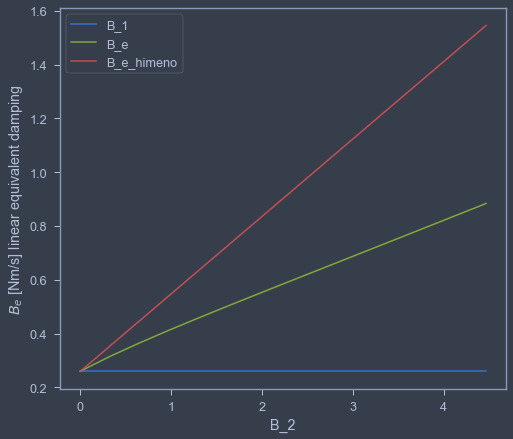

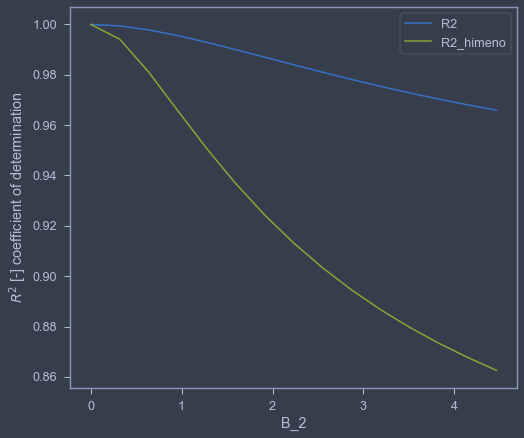

In [39]:
fig,ax=plt.subplots()
df_B_e.plot(y=['B_1','B_e','B_e_himeno'], ax=ax)
ax.set_ylabel('$B_e$ [Nm/s] linear equivalent damping')

fig,ax=plt.subplots()
df_B_e.plot(y=['R2','R2_himeno'],ax=ax)
ax.set_ylabel('$R^2$ [-] coefficient of determination')

## $B_2/2$

In [40]:
df_B_e = pd.DataFrame()
df_B_e.index.name='B_2'

for B_2, X in results.items():
    B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'B_e'] = B_e
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2'] = r2_score(y_true=X['phi'], y_pred=phi_pred)
    
    B_e_himeno = lambdas.B_e_lambda(B_1=B_1, B_2=B_2/2, omega0=omega0, phi_a=phi0)
    df_B_e.loc[B_2,'B_e_himeno'] = B_e_himeno
    phi_pred_himeno = simulate(B_e=B_e_himeno, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2_himeno'] = r2_score(y_true=X['phi'], y_pred=phi_pred_himeno)

df_B_e['B_1'] = B_1

Text(0, 0.5, '$R^2$ [-] coefficient of determination')

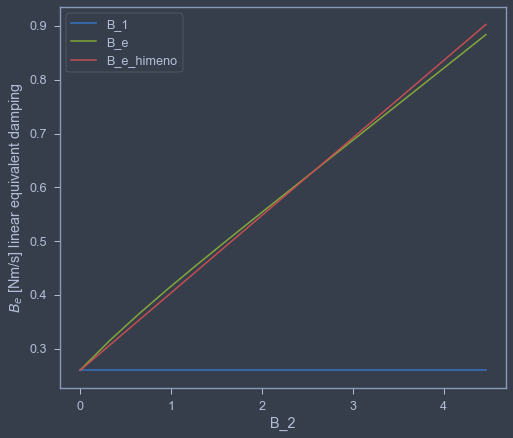

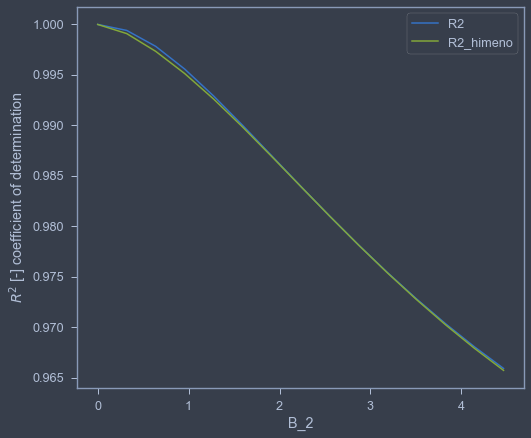

In [41]:
fig,ax=plt.subplots()
df_B_e.plot(y=['B_1','B_e','B_e_himeno'], ax=ax)
ax.set_ylabel('$B_e$ [Nm/s] linear equivalent damping')

fig,ax=plt.subplots()
df_B_e.plot(y=['R2','R2_himeno'],ax=ax)
ax.set_ylabel('$R^2$ [-] coefficient of determination')